100%|██████████| 83.7M/83.7M [00:00<00:00, 203MB/s]


[INFO] Processing 2018_7$largeimg04_Wednesday_2018_014321261.jpg
[INFO] Saved to dataset as /content/dataset/processed/2018_7$largeimg04_Wednesday_2018_014321261_1744260559.jpg


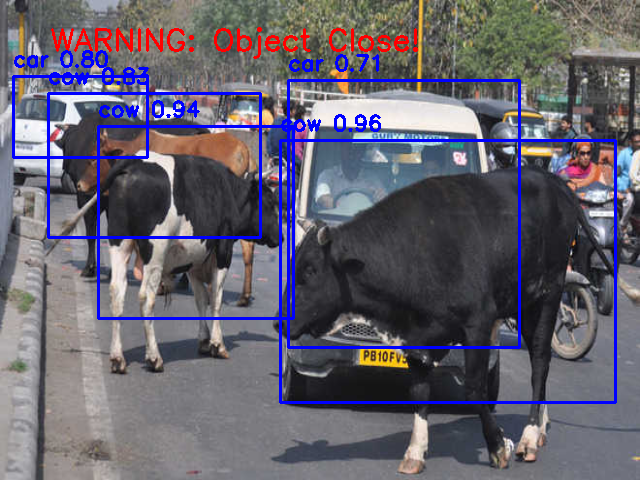

[INFO] Processing elk-car-mark-gocke-fix.jpg
[INFO] Saved to dataset as /content/dataset/processed/elk-car-mark-gocke-fix_1744260561.jpg


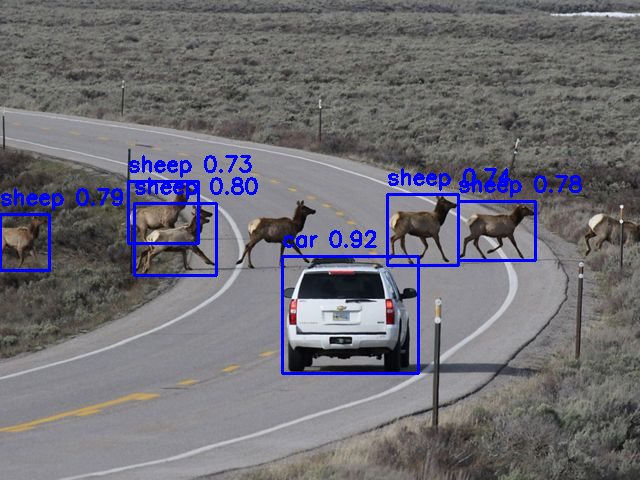


[INFO] Detection Summary:
True Positives (TP): 8
False Positives (FP): 3
False Negatives (FN): 0
Precision: 72.73%
Accuracy: 72.73%


In [8]:
# Install YOLO if not done already
!pip install -q ultralytics

import cv2
import os
import time
from google.colab.patches import cv2_imshow
from ultralytics import YOLO

# Load a better YOLO model (higher accuracy)
model = YOLO('yolov8l.pt')  # Try yolov8l.pt or yolov8x.pt for best performance

image_folder = [
    "/content/2018_7$largeimg04_Wednesday_2018_014321261.jpg",
    "/content/elk-car-mark-gocke-fix.jpg"
]

output_dir = "/content/dataset/processed/"
os.makedirs(output_dir, exist_ok=True)

TP, FP, FN = 0, 0, 0

allowed_classes = ['dog', 'cat', 'cow', 'sheep', 'horse', 'deer', 'bear', 'zebra', 'elephant']

for image_path in image_folder:
    image_filename = os.path.basename(image_path)

    if image_filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        print(f"[INFO] Processing {image_filename}")

        image = cv2.imread(image_path)
        if image is None:
            print(f"[ERROR] Image {image_filename} not found. Skipping.")
            continue

        image = cv2.resize(image, (640, 480))

        # --- Preprocessing ---
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
        gray = clahe.apply(gray)
        blur = cv2.GaussianBlur(gray, (3, 3), 0)

        edges = cv2.Canny(blur, 50, 150)
        combined = cv2.bitwise_or(edges, blur)

        contours, _ = cv2.findContours(combined, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        detected = False

        # --- Contour Filtering ---
        for contour in contours:
            area = cv2.contourArea(contour)
            if 800 < area < 50000:
                x, y, w, h = cv2.boundingRect(contour)
                cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
                detected = True

        # --- YOLO Detection ---
        yolo_results = model.predict(image_path, conf=0.5, iou=0.5, save=False, verbose=False)

        for r in yolo_results:
            for box in r.boxes:
                x1, y1, x2, y2 = map(int, box.xyxy[0])
                conf = box.conf[0]
                label = model.names[int(box.cls[0])]
                label_text = f'{label} {conf:.2f}'

                if conf > 0.7:  # Higher threshold for accuracy
                    cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
                    cv2.putText(image, label_text, (x1, y1 - 10),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)
                    detected = True

                    if label in allowed_classes:
                        TP += 1
                    else:
                        FP += 1

                    if y2 > 400:
                        cv2.putText(image, "WARNING: Object Close!", (50, 50),
                                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

        if not detected:
            FN += 1

        # --- Save Processed Image ---
        timestamp = int(time.time())
        clean_name = os.path.splitext(image_filename)[0]
        output_path = f"{output_dir}{clean_name}_{timestamp}.jpg"
        cv2.imwrite(output_path, image)
        print(f"[INFO] Saved to dataset as {output_path}")

        cv2_imshow(image)
        cv2.waitKey(0)

    else:
        print(f"[INFO] Skipping non-image file: {image_filename}")

cv2.destroyAllWindows()

# --- Accuracy & Precision ---
print("\n[INFO] Detection Summary:")
print(f"True Positives (TP): {TP}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")

precision = TP / (TP + FP + 1e-6)
accuracy = TP / (TP + FP + FN + 1e-6)

print(f"Precision: {precision * 100:.2f}%")
print(f"Accuracy: {accuracy * 100:.2f}%")
